In [75]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [76]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/train/'  # Path to the train dataset(Building vs Forest)
test_dir = '/content/drive/MyDrive/test'    # Path to test dataset(Building vs Forest)

In [77]:
#import os library to access file directories
import os

#list the directories
train_buildings = '/content/drive/MyDrive/train/buildings'
train_forests = '/content/drive/MyDrive/train/forests'
test_buildings = '/content/drive/MyDrive/test/buildings'
test_forests = '/content/drive/MyDrive/test/forests'

#method that can is used to calculate number of files using sum and for loop.
def total_images(train_buildings, train_forests, test_buildings, test_forests):
  calculate_trb = sum(1 for filename in os.listdir(train_buildings) if filename.endswith('.jpg'))
  calculate_trf = sum(1 for filename in os.listdir(train_forests) if filename.endswith('.jpg'))
  calculate_teb = sum(1 for filename in os.listdir(test_buildings) if filename.endswith('.jpg'))
  calculate_tef = sum(1 for filename in os.listdir(test_forests) if filename.endswith('.jpg'))
  return  calculate_trb, calculate_trf, calculate_teb, calculate_tef  #Return the sum of all files in their respective order

#Call the function
total = total_images(train_buildings, train_forests, test_buildings, test_forests)

#Display the sum
print(total)

(2190, 2253, 404, 474)


In [78]:
import pandas as pd
import numpy as np
import cv2

#reading the images for training and testing data
def importImages(file_directory):
  labels = []
  data = []
  #reading through the files to append labels to specific images
  for filename in os.listdir(file_directory):
    if filename.endswith('.jpg'):
      image = cv2.imread(os.path.join(file_directory, filename), cv2.IMREAD_COLOR)
      image = cv2.resize(image, (224, 224))
      data.append(image)
      label = "forests" if "forests" in filename else "buildings"
      labels.append(label)
  return np.array(data), np.array(labels)

#calling the function then display the result
#the output will display the amount of images, properties of image such as width and height, and the color channels of the images(RGB)
data, labels = importImages(train_buildings)
print(data.shape)
print(labels.shape)

data, labels = importImages(test_buildings)
print(data.shape)
print(labels.shape)




(2190, 224, 224, 3)
(2190,)
(404, 224, 224, 3)
(404,)


In [5]:
from sklearn.model_selection import train_test_split
#spliting training and testing data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=45)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(202, 128, 128, 3)
(202, 128, 128, 3)
(202,)
(202,)


In [79]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dataset = ImageDataGenerator(
    rescale=0.5,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.4
)

train_images = training_dataset.flow_from_directory(
   train_dir,
   target_size=(224, 224),
   batch_size=64,
   class_mode = 'binary',
   subset='training'
   )


testing_dataset = ImageDataGenerator(
    rescale=0.3,
    zoom_range=0.3,
    fill_mode = 'nearest',
    validation_split=0.4
)

test_images = testing_dataset.flow_from_directory(
   test_dir,
   target_size=(224, 224),
   batch_size=64,
   class_mode = 'binary',
   subset= 'validation'
   )


Found 2666 images belonging to 3 classes.
Found 350 images belonging to 3 classes.


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

#creating an vgg16 model
vgg16_pretrained = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_pretrained.trainable = False

#create a sequential model
#the model will a pretrained vgg16 model with batch normalization as well as ReLu Activation
#the model will a kernel size of 4,4 with a pool size of 2,2
#flattening out is included to flatten the previous
#2 convuntional layers is included with a size of 32 and 64
model = Sequential()
model.add(vgg16_pretrained)
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#ReLu activation is initialized with a dense layer of 32 and 128
#sigmoid activation is intiliazed with a dense layer of 1 for binary classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#adam optimization is added to ensure the parameters are constantly updated during training
#crossentrpoy is implemented to measure loss or unfamiliarity with labels(true) and predicated ones
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#summary of the model is displayed here
model.summary()

#models will be predicted using the fit function with a number of iterations which is two
history = model.fit(train_images, epochs=2, validation_data=validation_images)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_84 (Conv2D)          (None, 7, 7, 32)          262176    
                                                                 
 batch_normalization_27 (Ba  (None, 7, 7, 32)          128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 3, 3, 64)          32832     
                                                                 
 batch_normalization_28 (Ba  (None, 3, 3, 64)        

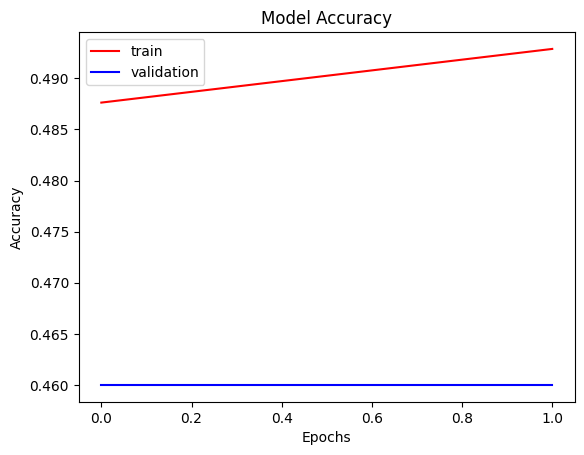

In [81]:
import matplotlib.pyplot as plt

#a graph will be ploted illustrating the accuracy of the prediction model
plt.plot(history.history['accuracy'], color='red',label='train')
plt.plot(history.history['val_accuracy'], color='blue',label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [82]:
#model will be tested to predict a set of test images to ensure that it has been trained properly
validation_labels = test_images.classes
predict_data = model.predict(test_images)
print(predict_data)

6/6 [==============================] - 221s 36s/step
[[0.9996331 ]
 [1.        ]
 [0.9999912 ]
 [0.9999901 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9998819 ]
 [0.9998905 ]
 [1.        ]
 [0.99996585]
 [1.        ]
 [1.        ]
 [0.9998122 ]
 [0.9999894 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999065 ]
 [1.        ]
 [0.99997485]
 [1.        ]
 [0.9999053 ]
 [1.        ]
 [1.        ]
 [0.9998654 ]
 [1.        ]
 [0.9999928 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999907 ]
 [1.        ]
 [1.        ]
 [0.99998224]
 [1.        ]
 [1.        ]
 [0.9999795 ]
 [1.        ]
 [0.9982568 ]
 [0.9999915 ]
 [1.        ]
 [1.        ]
 [0.99814236]
 [0.9999795 ]
 [0.99999154]
 [0.9999937 ]
 [1.        ]
 [0.9695751 ]
 [1.        ]
 [0.99993414]
 [1.        ]
 [1.        ]
 [0.9998493 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99948364]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99996334]
 [0.99988675]
 [0.99973

In [83]:
from sklearn.metrics import confusion_matrix, classification_report

#assign true labels
validation_labels = test_images.classes
predict_classes = (model.predict(test_images) > 0.5).astype(int)


# get validation labels and predict classes
confus_matrix = confusion_matrix(validation_labels, predict_classes)
print(confus_matrix)

# display confusion matrix
print("The Confusion Matrix is: ")
print(confus_matrix)

#display classification report
print("\nClassificationn Report is: ")
print(classification_report(validation_labels, predict_classes))



6/6 [==============================] - 207s 33s/step
[[161   0]
 [189   0]]
The Confusion Matrix is: 
[[161   0]
 [189   0]]

Classificationn Report is: 
              precision    recall  f1-score   support

           1       0.46      1.00      0.63       161
           2       0.00      0.00      0.00       189

    accuracy                           0.46       350
   macro avg       0.23      0.50      0.32       350
weighted avg       0.21      0.46      0.29       350



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
